# Figure 6: Phase Diagram (Parameter Space)

- **Goal**
 
 The goal of this notebook is to make a "phase diagram" of charge OP $\kappa$ in $(B,\omega)$ space.


In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

from tqdm import tqdm
sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, './../auxnumerics/')
sys.path.insert(0, '../')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo_colloids as mc
import vertices as vrt

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':11,
    'ytick.labelsize':11,
    'axes.labelsize':11,
})

In [4]:
DRIVE = os.path.join(os.path.expanduser('~'),'shorui/projects')
PROJECT = 'frequencygs/data/test11'
SIZE = 10
DATA_PATH = os.path.join(DRIVE,PROJECT,str(SIZE))
DATA_PATH

'/home/frieren/shorui/projects/frequencygs/data/test11/10'

In [5]:
data = pd.read_csv(os.path.join(DATA_PATH,'kappa_all.csv'))
data.t = np.round(data.t,3)
data.kappa = np.abs(data.kappa)
# get the mapping omega : max_time
maxt = {tt:dfw.t.max() for tt,dfw in data.groupby('total_time') }
# get the last frames
data_lastframes = pd.concat([data.query(f'total_time=={tt} & t=={tmax}') for tt,tmax in maxt.items()],axis=0)
# average across realizations
averaged = data_lastframes.groupby(['total_time','field','t'])['kappa'].mean().to_frame().reset_index()

In [6]:
averaged['omega'] = np.round(np.pi/2/averaged['total_time'],4)

omegas = averaged.omega.unique()
fields = averaged.field.unique()

W, B = np.meshgrid(omegas,fields)

In [8]:
rows,cols = W.shape

K = np.zeros(W.shape)
for i in range(rows):
    for j in range(cols):
        K[i,j] =  averaged.query(f'omega=={W[i,j]} & field=={B[i,j]}')['kappa'].to_numpy()[0]

K = K /4/params['size']**2

# this only discretices everything

#low = 0.01
#high = 0.99

#K[K<=low] = 0
#K[(K>low)*(K<=high)] = 0.5
#K[K>high] = 1

# Phase Map Only

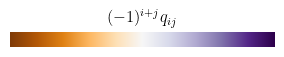

In [11]:
COL = 246/72
# Create a 2D array that goes from 0 to 1 horizontally
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack([gradient] * 20)  # Repeat it vertically to make it visible

# Plot it
fig, ax = plt.subplots(figsize=(COL,0.2),dpi=100)
ax.imshow(gradient, aspect='auto', cmap='PuOr')
ax.set_title("$(-1)^{i+j}q_{ij}$")
ax.set_axis_off()
plt.show()

fig.savefig("colorbar.pdf",dpi=300)


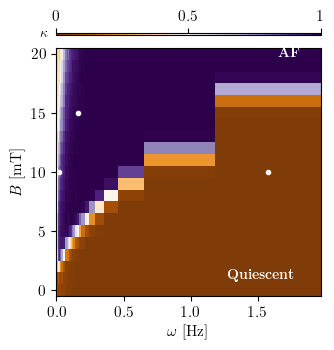

In [12]:
COL = 246/72
fig = plt.figure(figsize=(COL,COL),dpi=100)
gs = gridspec.GridSpec(2, 1, height_ratios=[0.01, 1], hspace=0.1)

# Thin colorbar axes at the top
cbax = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap('PuOr')

# Plot
c = ax.pcolormesh(W, B, K, norm=norm, cmap=cmap, rasterized=True)
ax.set_xlabel('$\\omega$ [Hz]', fontsize=11)
ax.set_ylabel('$B$ [mT]', fontsize=11)

# Colorbar on top
cbar = plt.colorbar(c, cax=cbax, orientation='horizontal')  # Orientation can be changed to horizontal if needed
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labeltop=True, labelbottom=False)
cbar.ax.set_xticks([0,0.5,1])
cbar.ax.set_xticklabels([0,0.5,1])
fig.text(0.08,0.87,'$\\kappa$')

position = ax.get_position()
x,y,w,h = (position.x0, position.y0, position.width, position.height)

fig.text(x+0.65,y+0.7,'\\textbf{AF}', color='white')
fig.text(x+0.5,y+0.05,'\\textbf{Quiescent}', color='white')

times = [1,10,100]
omegas = np.pi/2/np.array(times)
local_fields = [10,15,10]

ax.plot(omegas,local_fields,'o',markersize=3, color='white')
plt.show()

fig.savefig(os.path.join(os.getcwd(),'phasemap.pdf'),dpi=300,bbox_inches='tight')

# Vertex Maps

In [13]:
def plot_positions(trj, ax = None, linewidth=1,linecolor="k"):
    """Plot the trajectory with tiny sticks and circles"""
    
    if ax is None:
        ax = plt.gca()

    for i, trj_i in trj.iterrows():
    
        c = 0.7
        xm = trj_i.x- c * trj_i.dx
        xp = trj_i.x+ c * trj_i.dx
        ym = trj_i.y- c * trj_i.dy
        yp = trj_i.y+ c * trj_i.dy
        
        ax.plot([xm, xp], [ym, yp], 
                 color = linecolor, linewidth = linewidth, zorder = 1)
        d = np.linalg.norm(trj_i.filter(["dx", "dy", "dz"]))
    
        c = mpl.patches.Circle([trj_i.x+trj_i.cx, trj_i.y+trj_i.cy],
                               radius = abs(c * (d/2)), 
                               linewidth = linewidth,
                               facecolor = "w", edgecolor = "k",zorder = 2)
        ax.add_artist(c)

In [36]:
def class_vrt(vrt):
    """Classify vertices"""
    vrt = vrt.copy()
    #vrt["type"] = "none"
    vrt.loc[:, "type"] = "none"

    vrt.loc[vrt.query("charge == -4").index, "type"] = "I"
    vrt.loc[vrt.query("charge == +4").index, "type"] = "VI"
    vrt.loc[vrt.query("charge == -2").index, "type"] = "II"
    vrt.loc[vrt.query("charge == +2").index, "type"] = "V"
    vrt.loc[vrt.query("charge == 0 & (abs(dx)>0 | abs(dy)>0)").index, "type"] = "IV"
    vrt.loc[vrt.query("charge == 0 & ~(abs(dx)>0 | abs(dy)>0)").index, "type"] = "III"

    groups = dict(I="a", II = "b", III = "d", IV = "e", V = "b", VI = "a", none = "none")

    
    group_colors = dict(
        a = "midnightblue",
        b = "cornflowerblue",
        c = "deepskyblue",
        d = "peru",
        e = "tan",
        none = "none")
    
    #vrt["color"] = [group_colors[groups[v.type]] for i, v  in vrt.iterrows()]
    vrt.loc[:, "color"] = [group_colors[groups[v.type]] for i, v in vrt.iterrows()]
    return vrt


In [32]:
def plot_vrtclass(vrt, ax=None):
    """Plot vertexmap with custom colormap"""
    if ax is None:
        ax = plt.gca()

    # Map the type to numerical values
    cvalue = dict(I=0, II=1, III=3, IV=4, V=1, VI=0, none=0)

    # Define the color map (now with 6 colors for each category)
    cmap = mpl.colors.ListedColormap([
        "midnightblue",
        "cornflowerblue",
        "deepskyblue",
        "peru",
        "tan",
        "white"           # none (for 0 value)
    ])

    # Define the boundaries for the colormap
    bounds = [0, 1, 2, 3, 4, 5, 6]  # Map each value to its corresponding color
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # Map the data from the 'vrt' DataFrame
    vrt_map = vrt.set_index(["x", "y"]).type.unstack().map(lambda x: cvalue.get(x, 0))

    # Extract x, y, and values for pcolormesh
    x = vrt_map.index
    y = vrt_map.columns
    vrt_value = vrt_map.values

    # Plot the data using pcolormesh
    ax.pcolormesh(x, y, vrt_value.transpose(), cmap=cmap, norm=norm)

In [38]:
total_time = 1
field = 10

filename = f"{total_time}s_{field}mT"
trj = ice.trajectory(os.path.join(DATA_PATH,f'{filename}_trj.csv'))
v = trj.get_vertices(os.path.join(DATA_PATH,f'{filename}_vrt.csv'))
trj.load()

frames = trj.frames

last_trj = trj.trj.xs(frames[-2],level='frame')
last_vrt = v.vertices.xs(frames[-2],level='frame')
last_vrt = class_vrt(last_vrt)

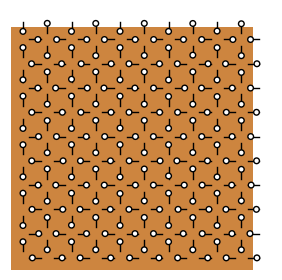

In [42]:
fig = plt.figure(figsize = np.array([8.6/2, 8.6/2]) / 2.54*2)
ax = plt.gca()

plot_vrtclass(last_vrt, ax = ax)
plot_positions(last_trj, ax = ax, linewidth = 1,linecolor='k')

plt.axis("equal")
plt.axis("off")
fig.savefig(f'./{filename}.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Plotting for the paper

first attempt.
Double column plot, "with examples"

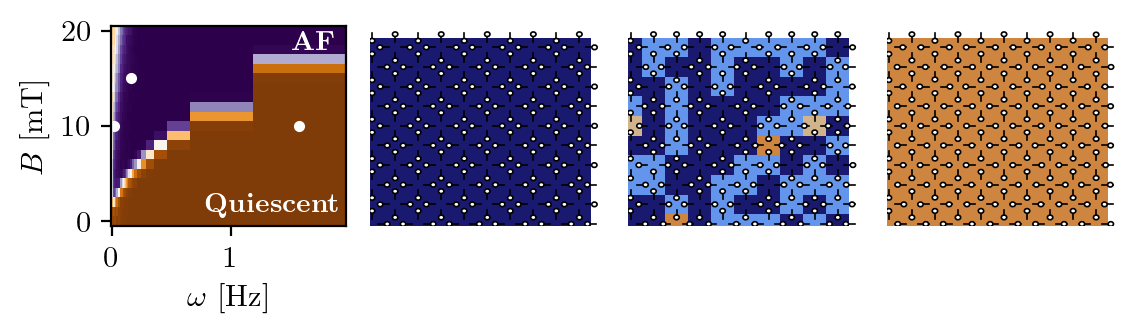

In [67]:
COL=510/72
OFFSET=(510-444.728)/72
OFFSET=1.1

labels = ['\\textbf{a)}',
          '\\textbf{b)}',
          '\\textbf{c)}',
          '\\textbf{d)}']

fig = plt.figure(figsize=(COL+OFFSET, 1.3),dpi=200)
gs = gridspec.GridSpec(1, 5, hspace=0, wspace=0.1)

size = fig.get_size_inches()
aspect_ratio = size[1]/size[0]
    
# ===========================================================
# Phase map
# ===========================================================
norm = plt.Normalize(0,1)
cmap = plt.get_cmap('PuOr')

ax = fig.add_subplot(gs[0])

c = ax.pcolormesh(W, B, K, norm=norm, cmap=cmap, rasterized=True)
ax.set_xlabel('$\\omega$ [Hz]',fontsize=11)
ax.set_ylabel('$B$ [mT]',fontsize=11)

ax.plot(omegas,local_fields,'o',markersize=3, color='w')


position = ax.get_position()
x,y,w,h = (position.x0, position.y0, position.width, position.height)


# ===========================================================
# The examples
# ===========================================================

colors = [cmap(norm(i)) for i in [1,0.5,0]]

times = [10,100,1]
omegas = np.pi/2/np.array(times)
local_fields = [15,10,10]

for i,(ctime, cfield) in enumerate(zip(times,local_fields)):
    
    ax = fig.add_subplot(gs[i+1])

    filename = f"{ctime}s_{cfield}mT"
    trj = ice.trajectory(os.path.join(DATA_PATH,f'{filename}_trj.csv'))
    v = trj.get_vertices(os.path.join(DATA_PATH,f'{filename}_vrt.csv'))
    trj.load()

    frames = trj.frames

    last_trj = trj.trj.xs(frames[-1],level='frame')
    last_vrt = v.vertices.xs(frames[-1],level='frame')
    last_vrt = class_vrt(last_vrt)

    plot_vrtclass(last_vrt, ax = ax)
    plot_positions(last_trj, ax = ax, linewidth = 0.6,linecolor='k')

    #ax.axis("equal")
    ax.axis("off")
    ax.set_xlim(-3,303)
    ax.set_ylim(-3,303)
    
    # dealing with the background boxes
    #position = ax.get_position()
    #x,y,w,h = (position.x0, position.y0, position.width, position.height)
    #pad = 0.02
    
    #rect = patches.Rectangle(
        #(x - aspect_ratio*pad, y - pad), 
        #w + 2*aspect_ratio*pad*(-0.), 
        #h + 2*pad*(-0.), 
        #color=colors[i], 
        #alpha=1, 
        #transform=fig.transFigure, 
        #zorder=0
    #)
    #fig.add_artist(rect)

fig.text(x+0.77*w,y+0.88*h,'\\textbf{AF}', color='white')
fig.text(x+0.4*w,y+0.05,'\\textbf{Quiescent}', color='white')

plt.show()

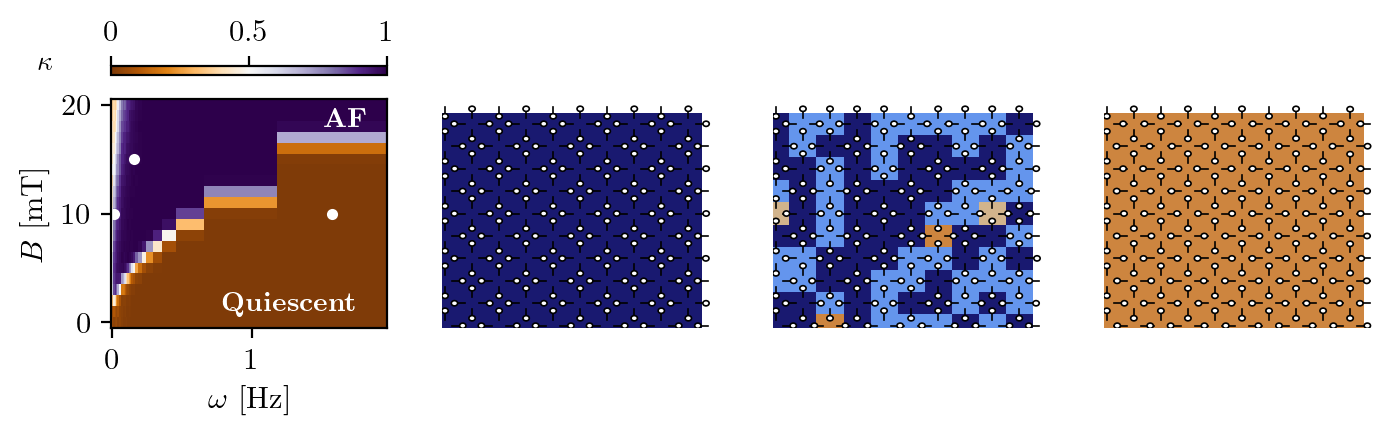

In [78]:
COL=510/72
OFFSET=(510-444.728)/72
OFFSET=1.1

labels = ['\\textbf{a)}',
          '\\textbf{b)}',
          '\\textbf{c)}',
          '\\textbf{d)}']

fig = plt.figure(figsize=(COL+OFFSET, 1.7),dpi=200)
gs = gridspec.GridSpec(2, 4, height_ratios=[0.04,1],wspace=0.2)

size = fig.get_size_inches()
aspect_ratio = size[1]/size[0]

norm = plt.Normalize(0,1)
cmap = plt.get_cmap('PuOr')
    
# ===========================================================
# Phase map
# ===========================================================
ax = fig.add_subplot(gs[1,0])

c = ax.pcolormesh(W, B, K, norm=norm, cmap=cmap, rasterized=True)
ax.set_xlabel('$\\omega$ [Hz]',fontsize=11)
ax.set_ylabel('$B$ [mT]',fontsize=11)
ax.plot(omegas,local_fields,'o',markersize=3, color='w')

# Thin colorbar axes at the top
cbax = fig.add_subplot(gs[0,0])
cbar = plt.colorbar(c, cax=cbax, orientation='horizontal')  # Orientation can be changed to horizontal if needed
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labeltop=True, labelbottom=False)
cbar.ax.set_xticks([0,0.5,1])
cbar.ax.set_xticklabels([0,0.5,1])
fig.text(0.08,0.87,'$\\kappa$')



position = ax.get_position()
x,y,w,h = (position.x0, position.y0, position.width, position.height)

# ===========================================================
# The examples
# ===========================================================

colors = [cmap(norm(i)) for i in [1,0.5,0]]

times = [10,100,1]
omegas = np.pi/2/np.array(times)
local_fields = [15,10,10]

for i,(ctime, cfield) in enumerate(zip(times,local_fields)):
    
    ax = fig.add_subplot(gs[1,i+1])

    filename = f"{ctime}s_{cfield}mT"
    trj = ice.trajectory(os.path.join(DATA_PATH,f'{filename}_trj.csv'))
    v = trj.get_vertices(os.path.join(DATA_PATH,f'{filename}_vrt.csv'))
    trj.load()

    frames = trj.frames

    last_trj = trj.trj.xs(frames[-1],level='frame')
    last_vrt = v.vertices.xs(frames[-1],level='frame')
    last_vrt = class_vrt(last_vrt)

    plot_vrtclass(last_vrt, ax = ax)
    plot_positions(last_trj, ax = ax, linewidth = 0.6,linecolor='k')

    #ax.axis("equal")
    ax.axis("off")
    ax.set_xlim(-3,303)
    ax.set_ylim(-3,303)

fig.text(x+0.77*w,y+0.88*h,'\\textbf{AF}', color='white')
fig.text(x+0.4*w,y+0.05,'\\textbf{Quiescent}', color='white')

fig.savefig('fig6.pdf',dpi=300, bbox_inches='tight')

plt.show()

second attempt 

In [ ]:
COL=246/72
OFFSET=(510-444.728)/72
OFFSET=1.1

labels = ['\\textbf{a)}',
          '\\textbf{b)}',
          '\\textbf{c)}',
          '\\textbf{d)}']

fig = plt.figure(figsize=(COL+OFFSET, 3),dpi=200)
gs = gridspec.GridSpec(4, 4, height_ratios=[0.05,1,1,1])

size = fig.get_size_inches()
aspect_ratio = size[1]/size[0]
    
# ===========================================================
# Phase map
# ===========================================================
ax = fig.add_subplot(gs[1:,:3])

norm = plt.Normalize(0,1)
cmap = plt.get_cmap('PuOr')


cbax = fig.add_subplot(gs[0,:3])
cbar = plt.colorbar(c, cax=cbax, orientation='horizontal')  # Orientation can be changed to horizontal if needed
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labeltop=True, labelbottom=False)
cbar.ax.set_xticks([0,0.5,1])
cbar.ax.set_xticklabels([0,0.5,1])
fig.text(0.08,0.87,'$\\kappa$')


c = ax.pcolormesh(W, B, K, norm=norm, cmap=cmap, rasterized=True)
ax.set_xlabel('$\\omega$ [Hz]',fontsize=11)
ax.set_ylabel('$B$ [mT]',fontsize=11)

#position = ax.get_position()
#x,y,w,h = (position.x0, position.y0, position.width, position.height)

#fig.text(x+0.65,y+0.7,'\\textbf{AF}', color='white')
#fig.text(x+0.5,y+0.05,'\\textbf{Quiescent}', color='white')

# ===========================================================
# The examples
# ===========================================================

colors = [cmap(norm(i)) for i in [1,0.5,0]]

times = [10,100,1]
omegas = np.pi/2/np.array(times)
local_fields = [15,10,10]

for i,(ctime, cfield) in enumerate(zip(times,local_fields)):
    
    ax = fig.add_subplot(gs[i+1,-1])

    filename = f"{ctime}s_{cfield}mT"
    trj = ice.trajectory(os.path.join(DATA_PATH,f'{filename}_trj.csv'))
    v = trj.get_vertices(os.path.join(DATA_PATH,f'{filename}_vrt.csv'))
    trj.load()

    frames = trj.frames

    last_trj = trj.trj.xs(frames[-1],level='frame')
    last_vrt = v.vertices.xs(frames[-1],level='frame')
    class_vrt(last_vrt)

    plot_vrtclass(last_vrt, ax = ax)
    plot_positions(last_trj, ax = ax, linewidth = 0.3,linecolor='k')

    #ax.axis("equal")
    ax.axis("off")
    ax.set_xlim(-3,303)
    ax.set_ylim(-3,303)
    

# Some maps animations

In [ ]:
total_time = 100
field = 10

filename = f"{total_time}s_{field}mT"
trj = ice.trajectory(os.path.join(DATA_PATH,f'{filename}_trj.csv'))
v = trj.get_vertices(os.path.join(DATA_PATH,f'{filename}_vrt.csv'))
trj.load()

frames = trj.frames

last_trj = trj.trj.xs(frames[0],level='frame')
last_vrt = v.vertices.xs(frames[0],level='frame')
class_vrt(last_vrt)

In [ ]:
# pre
total_time = 100
field = 10
omega = np.pi/2/total_time

filename = f"{total_time}s_{field}mT"
trj = ice.trajectory(os.path.join(DATA_PATH,f'{filename}_trj.csv'))
v = trj.get_vertices(os.path.join(DATA_PATH,f'{filename}_vrt.csv'))
trj.load()

frames = trj.frames



for i,cur_frame in enumerate(frames[::10]):
    fig = plt.figure(figsize = np.array([8.6/2, 8.6/2]) / 2.54*2, dpi=200)
    ax = plt.gca()
    cur_trj = trj.trj.xs(frames[cur_frame],level='frame')
    cur_time = cur_trj['t'][0]
    cur_vrt = v.vertices.xs(frames[cur_frame],level='frame')
    class_vrt(cur_vrt)

    plot_vrtclass(cur_vrt, ax = ax)
    plot_positions(cur_trj, ax = ax, linewidth = 1,linecolor='k')

    plt.axis("equal")
    plt.axis("off")
    ax.set_title(f'$t = {cur_time:.2f}$ s')
    ax.set_xlim(-3,303)
    ax.set_ylim(-3,303)
    fig.savefig(f'./videoslow/{i}.png',dpi=300,bbox_inches='tight')
    plt.close('all')

In [ ]:
# pre
total_time = 10
field = 15
omega = np.pi/2/total_time

filename = f"{total_time}s_{field}mT"
trj = ice.trajectory(os.path.join(DATA_PATH,f'{filename}_trj.csv'))
v = trj.get_vertices(os.path.join(DATA_PATH,f'{filename}_vrt.csv'))
trj.load()

frames = trj.frames



for i,cur_frame in enumerate(frames[::1]):
    fig = plt.figure(figsize = np.array([8.6/2, 8.6/2]) / 2.54*2, dpi=200)
    ax = plt.gca()
    cur_trj = trj.trj.xs(frames[cur_frame],level='frame')
    cur_time = cur_trj['t'][0]
    cur_vrt = v.vertices.xs(frames[cur_frame],level='frame')
    class_vrt(cur_vrt)

    plot_vrtclass(cur_vrt, ax = ax)
    plot_positions(cur_trj, ax = ax, linewidth = 1,linecolor='k')

    plt.axis("equal")
    plt.axis("off")
    ax.set_title(f'$t = {cur_time:.2f}$ s')
    ax.set_xlim(-3,303)
    ax.set_ylim(-3,303)
    fig.savefig(f'./videoslow/{i}.png',dpi=300,bbox_inches='tight')
    plt.close('all')

In [ ]:
(np.array(frames)/20)[-1]